# Compressed Sesing Reconcstruction
## Introduction
This notebook shows basic examples for compressed sensing reconstruction problems with different algorithms.

## Basic reconstruction idea with norm relaxation

Assum the basic $l_0$ minimzation problem from CS:

$$\min_{\mathbf{x}\in\mathbb{R}}\lVert \mathbf{x} \rVert_0\quad\mathrm{s.t.}\quad \lVert \mathbf{y}-\mathbf{A}\mathbf{x}\rVert < \epsilon$$

Then, we can relax the $l_0$ "norm" to another norm like the convex $l_1$ norm:

$$\min_{\mathbf{x}\in\mathbb{R}}\lVert \mathbf{x} \rVert_1\quad\mathrm{s.t.}\quad \lVert \mathbf{y}-\mathbf{A}\mathbf{x}\rVert < \epsilon$$

In the noiseless case, the constraint simplifies to $\mathbf{A}\mathbf{x}=\mathbf{y}$. Thus, the solution is at the intersection of the hyperplanes defined by the equation system and the scales unit sphere in the chosen norm. The following code illustrates this with a 2D example. Feasible $\mathbf{x}$ that solve $\mathbf{A}\mathbf{x}=\mathbf{y}$ are on the blue line. This line then touches the scaled unit sphere (green) of different norms at different points (red). Note, that it only leads to a sparse solution for the $l_1$ norm.

<IPython.core.display.Javascript object>


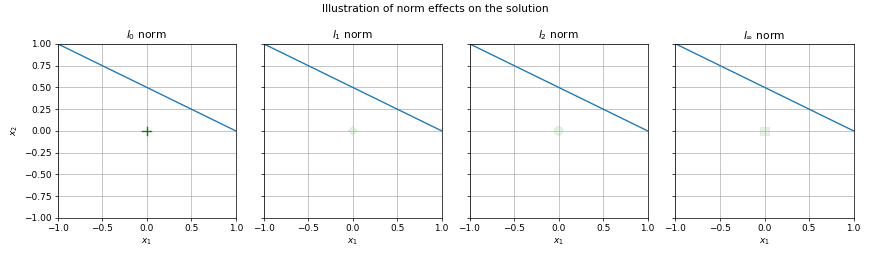

In [267]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from numpy import linspace
from math import sqrt

x1 = linspace(-1,1,10)
fig,axs = plt.subplots(1, 4, sharey=True)
fig.set_figwidth(13.5)
fig.suptitle("Illustration of norm effects on the solution")
fig.set_tight_layout(True)

for ax in axs:
    ax.plot(x1,(1-x1)/2)
    ax.set_xlim((-1,1))
    ax.set_ylim((-1,1))
    ax.set_xlabel('$x_1$')
    ax.grid(True)
    
axs[0].set_title('$l_0$ norm')
axs[0].set_ylabel('$x_2$')
axs[1].set_title('$l_1$ norm')
axs[2].set_title('$l_2$ norm')
axs[3].set_title('$l_\infty$ norm')

zero_norm = axs[0].plot([0,0],[0, 0],'g-',[0, 0],[0,0],'g-')

at=[]
line=[]
line.append(axs[0].plot(0,0.5,'rs'))
at.append(axs[0].annotate('(0,0.5)',(0.05,0.55)))

line.append(axs[1].plot(0,0.5,'rs'))
at.append(axs[1].annotate('(0,0.5)',(0.05,0.55)))

line.append(axs[2].plot(1/5,2/5,'rs'))
at.append(axs[2].annotate('(1/5,2/5)',(1/5+0.05,2/5+0.05)))
    
line.append(axs[3].plot(1/3,1/3,'rs'))
at.append(axs[3].annotate('(1/3,1/3)',(1/3+0.05,1/3+0.05)))

for i in [0,1,2,3]:
    line[i][0].set_marker(' ')
    at[i].set_visible(False)
        
sp_space=[]
sp_space.append(linspace(0.05,0.5,100))
sp_space.append(linspace(0.05,0.5,100))
sp_space.append(linspace(0.05,1/sqrt(5),100))
sp_space.append(linspace(0.05,1/3,100))

def update(change):
    zero_norm[0].set_data([-sp_space[0][change.new], sp_space[0][change.new]],[0, 0])
    zero_norm[1].set_data([0, 0],[-sp_space[0][change.new], sp_space[0][change.new]])
    
    blen=sqrt(sp_space[0][change.new]**2+sp_space[0][change.new]**2)
    axs[1].patches = []
    axs[1].add_patch(Rectangle((0,-sp_space[0][change.new]),blen,blen,45,color='g',alpha=0.1))
    
    axs[2].patches = []
    axs[2].add_patch(Circle((0,0),sp_space[2][change.new],color='g',alpha=0.1))
    
    axs[3].patches = []
    axs[3].add_patch(Rectangle((-sp_space[3][change.new],-sp_space[3][change.new]),2*sp_space[3][change.new],2*sp_space[3][change.new],0,color='g',alpha=0.1))   
    
    if change.new > 97:                      
        for i in [0,1,2,3]:
            line[i][0].set_marker('s')
            at[i].set_visible(True)
    else:
        for i in [0,1,2,3]:
            line[i][0].set_marker(' ')
            at[i].set_visible(False)
    
play = widgets.Play(
    interval=50,
    value=0,
    min=0,
    max=100,
    step=1,
    description="Press play",
    disabled=False
)
slider = widgets.IntSlider()
play.observe(update, 'value')
widgets.jslink((play, 'value'), (slider, 'value'))
widgets.HBox([play, slider])